# Open Data Rat Complaints

We know that 311 service requests can be found on Open Data [here](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data). This dataset is large, so we should use the API query to access it!

## Socrata API

In [1]:
# Ensure you have all of your packages installed
# !pip install sodapy

In [2]:
import pandas as pd
import os
from sodapy import Socrata
import time
import math

import matplotlib.pyplot as plt

Using the [API documentation](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9), we can see that the dataset id is "erm2-nwe9" (which is also in the open data hyperlink).

You should generally use an [application token](https://dev.socrata.com/docs/app-tokens.html) when accessing the Socrata Open Data API. Otherwise you'll be subjected to strict throttling limits. I recommend saving your token as an environment variable, but you can also use a string (just be careful not to save your token in a public place, like in a public github repo).

In [3]:
# I would recommend saving your socrata token as an environment variable!
app_token = os.getenv('SOCRATA_API')
# You could also save it as a string. The default is None. 
# SOCRATA_API = None

# Save the 311 dataset id
dataset_id = 'erm2-nwe9'

The Socrata API lets you filter your data, which helps when you're using large datasets. 
Some of the standard filters can be found [here](https://dev.socrata.com/docs/queries/).
It's often helpful to filter on dates, which can be a bit trickier ([link](https://dev.socrata.com/docs/transforms/)). 

In [4]:
where_str = '''
1=1 AND (
((complaint_type = 'School Maintenance') AND (descriptor = 'Rodents/Mice'))
OR ((complaint_type = 'Food Establishment') AND (descriptor = 'Rodents/Insects/Garbage'))
OR ((complaint_type = 'Rodent') AND (descriptor = 'Rat Sighting'))
OR ((complaint_type = 'Rodent') AND (descriptor = 'Signs of Rodents'))
OR ((complaint_type = 'Maintenance or Facility') AND (descriptor = 'Rodent Sighting'))
OR ((complaint_type = 'Dead Animal') AND (descriptor = 'Rat or Mouse'))
OR ((complaint_type = 'UNSANITARY CONDITION') AND (descriptor = 'PESTS'))
) AND (date_trunc_ymd(created_date) >= '2019-01-01')
'''

In [5]:
%%time

# Note that you likely need to change the data limit
client = Socrata("data.cityofnewyork.us", app_token)
# timeout; default is 10sec
client.timeout = 120

results = client.get(dataset_id, where=where_str, limit=1000000)
opendata_df = pd.DataFrame.from_records(results)
print('Check if shape looks reasonable (does it match the provided limit?)')
opendata_df.shape

Check if shape looks reasonable (does it match the provided limit?)
CPU times: user 12.3 s, sys: 1.46 s, total: 13.7 s
Wall time: 41.9 s


(450653, 38)

I also wrote a small program (saved in socrata.py) that does this for you.

In [6]:
from socrata import socrata_api_query

rat_df = socrata_api_query(
    dataset_id=dataset_id,
    where=where_str,
    limit=1000000
)
rat_df.shape

Running query...
Duration: 0 min 48.1 sec


(450653, 38)

In [7]:
rat_df['created_date_dt'] = pd.to_datetime(rat_df['created_date'])
rat_df['year'] = rat_df['created_date_dt'].dt.isocalendar().year
rat_df['month'] = rat_df['created_date_dt'].dt.month

## Merge in geographic features

In [8]:
# !pip install geopandas
# !pip install shapley

In [9]:
import geopandas as gpd
from shapely.geometry import shape

In [10]:
keep_row = (
    (rat_df['created_date_dt'].dt.year == 2024)
    & (rat_df['created_date_dt'].dt.month == 9)
)
recent_rat_df = rat_df.loc[keep_row].copy()

In [11]:
rat_gdf = gpd.GeoDataFrame(
    recent_rat_df, crs='epsg:4326', 
    geometry=gpd.points_from_xy(recent_rat_df['longitude'], recent_rat_df['latitude'])
)

Get NYC borough geometries from Open Data ([link](https://data.cityofnewyork.us/dataset/nybb/7t3b-ywvw/about_data)).

In [12]:
nybb_df = socrata_api_query(dataset_id='7t3b-ywvw')
nybb_df['geometry'] = [shape(geo) for geo in nybb_df['the_geom']]

nybb_gdf = gpd.GeoDataFrame(
    data=nybb_df,
    geometry='geometry',
    crs='EPSG:4326'
)

Running query...
Duration: 0 min 1.084 sec


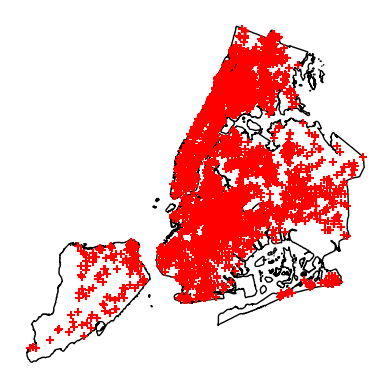

In [13]:
fig, ax = plt.subplots()

nybb_gdf.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black", facecolor='none')
rat_gdf.plot(ax=ax, marker='+', color='red')

ax.axis('off')

plt.show()

## Changes in Rat population

In [14]:
def count_sr_num(
    geo=None, 
    keep_after_year=2022, 
    groupvars=['year', 'month', 'agency', 'complaint_type', 'descriptor']
):
    '''Count service requests (311 calls) after 2022'''
    
    if geo is not None: 
        groupvars = [geo] + groupvars
    
    sr_num_count = (
        rat_df.loc[rat_df['year'] >= keep_after_year]
        .groupby(groupvars)['unique_key'].count()
    )

    sr_num_count.sort_index(
        axis=0,
        level=groupvars,
        inplace=True
    )

    sr_num_count = sr_num_count.reset_index()
    
    sr_num_count.rename(columns={'unique_key': 'count'}, inplace=True)
    
    return sr_num_count

In [18]:
sr_count_all = count_sr_num()
sr_count_all['geography'] = 'ALL NYC'

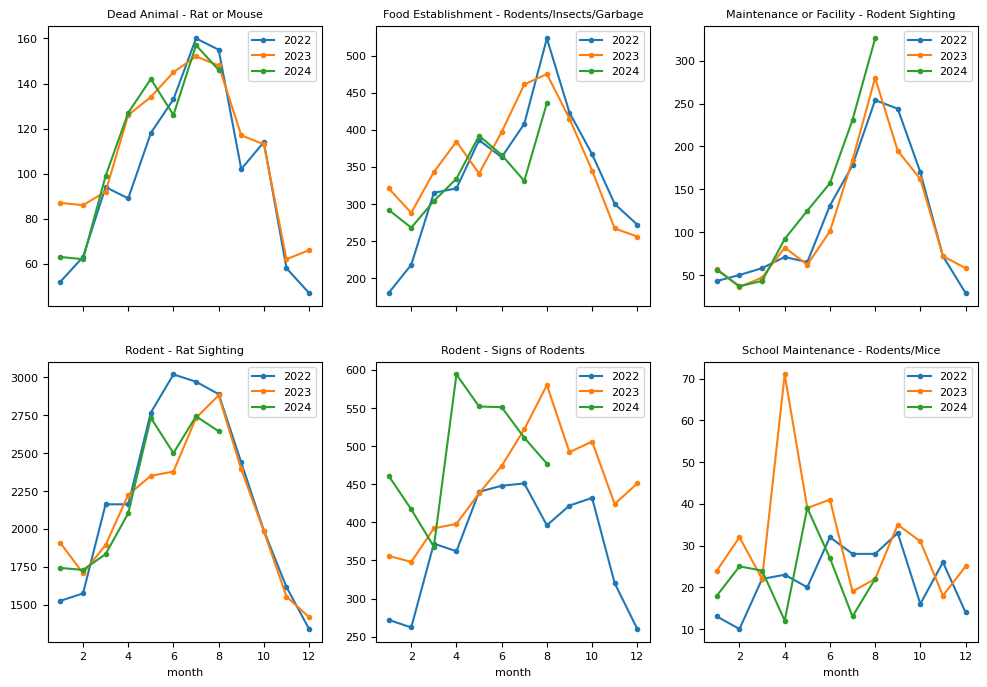

In [20]:
monthly_df = sr_count_all.drop(columns='geography')

# drop month with incomplete data
drop_row = ((monthly_df['year'] == 2024) & (monthly_df['month'] == 9))
drop_idx = monthly_df.loc[drop_row].index
monthly_df.drop(index=drop_idx, inplace=True)

# format title of plots
monthly_df['complaint'] = monthly_df['complaint_type'] + ' - ' + monthly_df['descriptor']
# weekly_df[['year', 'month', 'complaint',]]
monthly_df = monthly_df.pivot(index='month', columns=['complaint', 'year'], values='count')

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

for col, ax in zip(monthly_df.columns.levels[0], axes.flatten()):
    
    monthly_df[col].plot(ax=ax, marker='.')
    
    ax.set_title(col, size=8)
    
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    ax.legend(fontsize=8)
    
    ax.set_xlabel('month', fontsize=8)

In [21]:
sr_count_boro = count_sr_num(geo='borough', groupvars=['year', 'month'])

drop_row = sr_count_boro.loc[sr_count_boro['borough'] == 'Unspecified']
drop_idx = drop_row.index
sr_count_boro = sr_count_boro.drop(index=drop_idx)

sr_count_boro.rename(columns={'borough': 'geography'}, inplace=True)

(0.44999999999999996, 12.55, 0.0, 1.0)

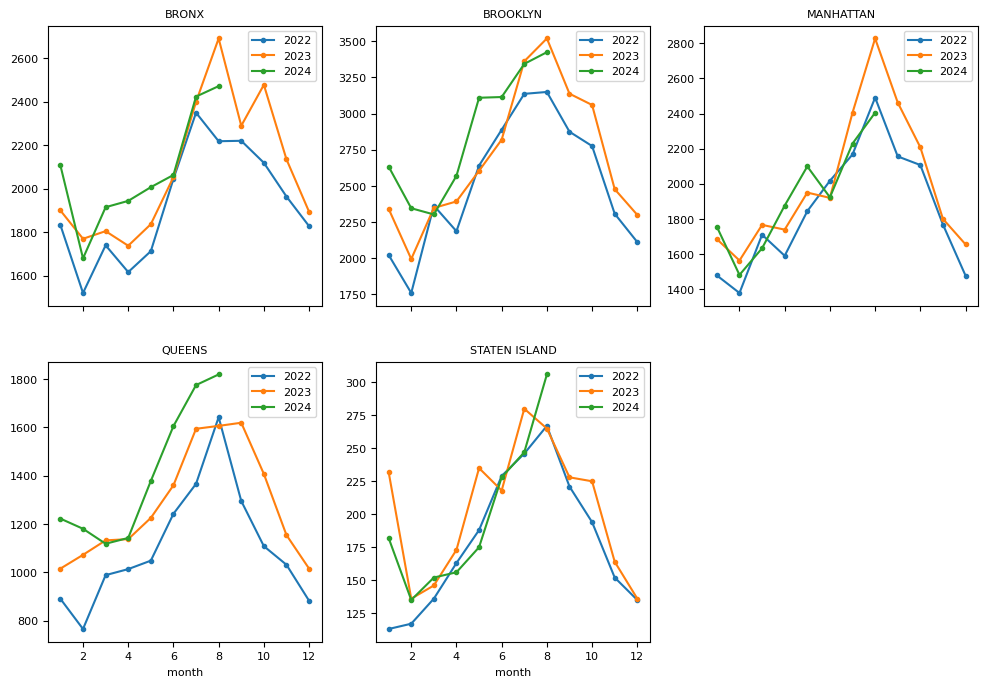

In [23]:
monthly_df = sr_count_boro.copy()

# drop month with incomplete data
drop_row = ((monthly_df['year'] == 2024) & (monthly_df['month'] == 9))
drop_idx = monthly_df.loc[drop_row].index
monthly_df.drop(index=drop_idx, inplace=True)

# pivot data to plot
monthly_df = monthly_df.pivot(index='month', columns=['geography', 'year'], values='count')

# generate plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

for col, ax in zip(monthly_df.columns.levels[0], axes.flatten()):
    
    monthly_df[col].plot(ax=ax, marker='.')
    
    ax.set_title(col, size=8)
    
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    ax.legend(fontsize=8)
    
    ax.set_xlabel('month', fontsize=8)
    
axes[1, 2].axis('off')